In [ ]:
############################
### Approche du document ###
############################


Le document présente une approche basée sur un Sparse Autoencoder (SAE) pour la détection d''anomalies 
et la maintenance prédictive.

#################################################################
### Caractéristiques principales de l''approche du document : ###
#################################################################   

- Apprentissage non supervisé : Le modele est entrainé uniquement avec des données normales pour détecter les anomalies.
- Utilisation d’un Sparse Autoencoder (SAE) : Un réseau de neurones avec des couches encodage/décodage pour apprendre 
              des représentations compressées des données.
- Données segmentées en Trun et Tidle : Détection des cycles du compresseur et extraction de caractéristiques 
              en bins (7 bins pour la pression et le courant moteur).
- Application d''un Filtre Passe-Bas (LPF) : Réduction des fausses alarmes en lissant les anomalies détectées.
- Seuil de détection basé sur l''IQR : Définition d''un seuil via la méthode du Boxplot (Q3 + k*IQR, avec k optimisé).
- Détection des anomalies sur des fenêtres temporelles : Analyse des anomalies sur une fenetre de 30 minutes avant la panne.
- Comparaison avec un Variational Autoencoder (VAE) : SAE s’est révélé plus performant que le VAE.

################################################    
### Parametres du modèle dans le document : ###
################################################

Paramètre	SAE Analog	SAE Digital
Neurones 1ère couche	128		36
Neurones 2ème couche	64		18
Neurones 3ème couche	32		-
Bottleneck Layer		12		6
Batch size				30		40
Époques					100		100

Paramètre de pénalité de sparsité (β)	5		6
Taux de régularisation (λ)				1e-5	2e-5
Seuil de détection	Q3 + 3 * IQR	Q3 + 3 * IQR


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Chargement des données
df = pd.read_csv(r"..\..\..\Datasources\MetroPT3_new_imputed_final.csv", delimiter=",", decimal=".", index_col=0)
df.reset_index(drop=True, inplace=True)
# Convertir timestamp en datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [2]:
############################################################
## Étape 1 : Générer Trun et Tidle (Cycle du Compresseur) ##
############################################################


# Détecter les changements d'état du compresseur
df["comp_state_change"] = df["COMP"].diff().fillna(0)  # Détection des changements d'état

# Identifier les moments où le compresseur démarre et s'arrête
df["comp_start"] = (df["comp_state_change"] == 1).astype(int)  # Démarrage
df["comp_stop"] = (df["comp_state_change"] == -1).astype(int)  # Arrêt

# Calculer les durées des phases Trun (compresseur actif) et Tidle (compresseur inactif)
df["Trun"] = df["timestamp"].diff().where(df["comp_start"] == 1).fillna(pd.Timedelta(seconds=0))
df["Tidle"] = df["timestamp"].diff().where(df["comp_stop"] == 1).fillna(pd.Timedelta(seconds=0))

# Convertir en secondes
df["Trun"] = df["Trun"].dt.total_seconds().fillna(0)
df["Tidle"] = df["Tidle"].dt.total_seconds().fillna(0)


In [3]:
############################################################
## Étape 2 : Générer BTP3 et BMC (Segmentation en Bins)   ##
############################################################

# Définir le nombre de bins (7 comme dans le document)
num_bins = 7  

# Créer les bins pour TP3 et Motor_current
df["BTP3"] = pd.cut(df["TP3"], bins=num_bins, labels=False)
df["BMC"] = pd.cut(df["Motor_current"], bins=num_bins, labels=False)

# Remplacer les valeurs NaN par 0 (au cas où)
df["BTP3"] = df["BTP3"].fillna(0)
df["BMC"] = df["BMC"].fillna(0)


In [4]:
############################################################
## Étape 3 : Vérification                                 ##
############################################################

print(df[["Trun", "Tidle", "BTP3", "BMC"]].head())

   Trun  Tidle  BTP3  BMC
0   0.0    0.0     5    4
1   0.0    0.0     5    4
2   0.0    0.0     6    4
3   0.0    0.0     6    4
4   0.0    0.0     6    4


In [5]:
features = ["TP3", "Motor_current", "Trun", "Tidle", "BTP3", "BMC", 
            "COMP", "DV_eletric", "Towers", "MPG", "LPS", "Pressure_switch", "Caudal_impulses"]

# Normalisation
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [6]:
########################################################################
## Étape 4 : Construction et Entraînement du SAE (Sparse Autoencoder) ##
########################################################################

import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Paramètre de sparsité β (issu du document)
beta = 5  # aussi à tester avec 6

# Paramètre de sparsité ρ (probabilité de moyenne d’activation souhaitée)
rho = 0.05  # Valeur typique entre 0.01 et 0.1

# Fonction de pénalité KL divergence
def sparsity_penalty(rho, rho_hat):
    return rho * np.log(rho / rho_hat) + (1 - rho) * np.log((1 - rho) / (1 - rho_hat))

# Définition du modèle Sparse Autoencoder (basé sur le document)
input_dim = len(features)

inputs = Input(shape=(input_dim,))
encoded = Dense(128, activation="relu")(inputs)
encoded = Dense(64, activation="relu")(encoded)
encoded = Dense(32, activation="relu")(encoded)

# Bottleneck avec activation sigmoid pour mesurer l'activation moyenne
bottleneck = Dense(8, activation="sigmoid", name="bottleneck")(encoded)

decoded = Dense(32, activation="relu")(bottleneck)
decoded = Dense(64, activation="relu")(decoded)
decoded = Dense(128, activation="relu")(decoded)
outputs = Dense(input_dim, activation="linear", name="reconstruction")(decoded)

# Création du modèle SAE
sae = Model(inputs, outputs)

# Création d'un modèle auxiliaire pour récupérer les activations de bottleneck
bottleneck_model = Model(inputs, bottleneck)

# Fonction de perte classique (sans pénalité directement dans la loss)
def sparse_autoencoder_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))  # Erreur de reconstruction

# Compilation du modèle avec la fonction de perte classique
sae.compile(optimizer="adam", loss=sparse_autoencoder_loss)

# Définition du callback pour la pénalité de sparsité
class SparsityRegularizer(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Récupérer les activations de la couche bottleneck via le modèle auxiliaire
        bottleneck_activations = bottleneck_model.predict(df[features], batch_size=32)

        # Utiliser np.mean() au lieu de K.mean() car les valeurs sont des tableaux NumPy
        rho_hat = np.mean(bottleneck_activations, axis=0)

        # Calcul de la pénalité de sparsité en NumPy
        sparsity_loss = beta * np.sum(sparsity_penalty(rho, rho_hat))

        # Ajouter la pénalité au loss total
        logs["loss"] += float(sparsity_loss)

# Entraînement du modèle avec EarlyStopping et pénalité de sparsité
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
sparsity_callback = SparsityRegularizer()

df_noisy = df[features] + 0.01 * np.random.normal(size=df[features].shape)
sae.fit(df_noisy, df[features], epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, sparsity_callback])


Epoch 1/50
25861/25861 ━━━━━━━━━━━━━━━━━━━━ 25s 980us/step
20688/20688 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - loss: 0.0304 - val_loss: 0.0031
Epoch 2/50
25861/25861 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
20688/20688 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 3/50
25861/25861 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step
20688/20688 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 4/50
25861/25861 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step
20688/20688 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/50
25861/25861 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
20688/20688 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/50
25861/25861 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
20688/20688 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/50
25861/25861 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step
20688/20688 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/50
25861/25861 ━━━━━━━━━━━━━━━━

In [14]:
#############################################
## Étape 5 : Sauvegarde du modele entrainé ##
#############################################

sae.save(r"..\Generated_Files\SAE\sae_trained_as_document.keras")
print("Entraînement terminé avec EarlyStopping, modèle sauvegardé !")

# Reconstruction des données
X_reconstructed = sae.predict(df[features])
df["error"] = np.mean(np.square(df[features] - X_reconstructed), axis=1)

Entraînement terminé avec EarlyStopping, modèle sauvegardé !
25861/25861 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step


In [15]:
# Dataset commence le 2020-04-12 11:20:00 et se termine le 2020-07-17 06:00:00
pannes = [
    {'id': 'Panne1',  'start': '2020-04-12 11:50:00', 'end': '2020-04-12 23:30:00'},
    {'id': 'Panne2',  'start': '2020-04-18 00:00:00', 'end': '2020-04-18 23:59:00'},
    {'id': 'Panne3',  'start': '2020-04-19 00:00:00', 'end': '2020-04-19 01:30:00'},
    {'id': 'Panne4',  'start': '2020-04-29 03:20:00', 'end': '2020-04-29 04:00:00'},
    {'id': 'Panne5',  'start': '2020-04-29 22:00:00', 'end': '2020-04-29 22:20:00'},
    {'id': 'Panne6',  'start': '2020-05-13 14:00:00', 'end': '2020-05-13 23:59:00'},
    {'id': 'Panne7',  'start': '2020-05-18 05:00:00', 'end': '2020-05-18 05:30:00'},
    {'id': 'Panne8',  'start': '2020-05-19 10:10:00', 'end': '2020-05-19 11:00:00'},
    {'id': 'Panne9',  'start': '2020-05-19 22:10:00', 'end': '2020-05-19 23:59:00'},
    {'id': 'Panne10', 'start': '2020-05-20 00:00:00', 'end': '2020-05-20 20:00:00'},
    {'id': 'Panne11', 'start': '2020-05-23 09:50:00', 'end': '2020-05-23 10:10:00'},
    {'id': 'Panne12', 'start': '2020-05-29 23:30:00', 'end': '2020-05-29 23:59:00'},
    {'id': 'Panne13', 'start': '2020-05-30 00:00:00', 'end': '2020-05-30 06:00:00'},
    {'id': 'Panne14', 'start': '2020-06-01 15:00:00', 'end': '2020-06-01 15:40:00'},
    {'id': 'Panne15', 'start': '2020-06-03 10:00:00', 'end': '2020-06-03 11:00:00'},
    {'id': 'Panne16', 'start': '2020-06-05 10:00:00', 'end': '2020-06-05 23:59:00'},
    {'id': 'Panne17', 'start': '2020-06-06 00:00:00', 'end': '2020-06-06 23:59:00'},
    {'id': 'Panne18', 'start': '2020-06-07 00:00:00', 'end': '2020-06-07 14:30:00'},
    {'id': 'Panne19', 'start': '2020-07-08 17:30:00', 'end': '2020-07-08 19:00:00'},
    {'id': 'Panne20', 'start': '2020-07-15 14:30:00', 'end': '2020-07-15 19:00:00'},
    {'id': 'Panne21', 'start': '2020-07-17 04:30:00', 'end': '2020-07-17 05:30:00'}
         ]

In [29]:
######################################################
## Étape 6 : Application du Filtre Passe-Bas (LPF) ##
######################################################

def low_pass_filter(data, alpha=0.08):  # α = 0.04 comme dans le document
    filtered_data = []
    prev = data[0]
    for point in data:
        new_value = prev + alpha * (point - prev)
        filtered_data.append(new_value)
        prev = new_value
    return filtered_data

df["filtered_error"] = low_pass_filter(df["error"], alpha=0.04)

In [30]:
##########################################################
## Étape 7 : Détection des Anomalies avec Q3 + 3 * IQR ##
#########################################################

Q1 = df["filtered_error"].quantile(0.25)
Q3 = df["filtered_error"].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 0.05 * IQR  # Comme dans le document

df["anomaly"] = df["filtered_error"] > threshold

In [31]:
########################################################################
## Étape 8 : Détection des Pannes Basée sur une Séquence d’Anomalies ##
#######################################################################

# Nombre minimal d'anomalies consécutives pour déclarer une panne
min_seq = 2  # Ajuster selon le besoin

# Créer une colonne qui compte les séquences d'anomalies
df["anomaly_seq"] = df["anomaly"].rolling(window=min_seq).sum()

# Détecter une panne si au moins `min_seq` anomalies consécutives
df["failure_detected"] = df["anomaly_seq"] >= min_seq

In [32]:
#######################################################################
## Étape 9 : Vérification des Anomalies 30 Minutes Avant Panne       ##
#######################################################################

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

time_window = pd.Timedelta(minutes=30)
anomalies_detectees = 0
total_pannes = len(pannes)

# Création des listes pour les évaluations
y_true = []  # Valeurs réelles (0: pas de panne, 1: panne détectée)
y_pred = []  # Prédictions du modèle (0: normal, 1: anomalie détectée)

for panne in pannes:
    pre_panne = pd.to_datetime(panne["start"]) - time_window
    anomalies_avant_panne = df[(df["timestamp"] >= pre_panne) & 
                               (df["timestamp"] < panne["start"]) & 
                               (df["failure_detected"])]

    # Marquer une panne détectée si au moins une anomalie avant la panne
    y_true.append(1)  # Il y avait une panne
    y_pred.append(1 if anomalies_avant_panne.shape[0] > 0 else 0)

    if anomalies_avant_panne.shape[0] > 0:
        anomalies_detectees += 1

# Convertir `failure_detected` en liste d'étiquettes 0/1 avec la même taille que `y_true`
df_predictions = df.loc[df["timestamp"].isin([p["start"] for p in pannes]), "failure_detected"].astype(int).tolist()

# S'assurer que `y_true` et `y_pred` ont la même taille
y_pred = y_pred[:len(y_true)]  # Ajuste la taille pour éviter l'erreur
df_predictions = df_predictions[:len(y_true)]  # Ajuste la taille

# Calcul des métriques
precision = precision_score(y_true, df_predictions)
recall = recall_score(y_true, df_predictions)
f1 = f1_score(y_true, df_predictions)
tn, fp, fn, tp = confusion_matrix(y_true, df_predictions).ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs

# Affichage des résultats
print("Évaluation du Modèle :")
print(f"Précision : {precision:.2f}")
print(f"Recall (Taux de détection des pannes) : {recall:.2f}")
print(f"F1-Score : {f1:.2f}")
print(f"Taux de Faux Positifs (FPR) : {fpr:.2f}")


Évaluation du Modèle :
Précision : 1.00
Recall (Taux de détection des pannes) : 0.29
F1-Score : 0.44
Taux de Faux Positifs (FPR) : nan


C:\Users\usermine\AppData\Local\Temp\ipykernel_17916\551081971.py:40: RuntimeWarning: invalid value encountered in scalar divide
  fpr = fp / (fp + tn)  # Taux de faux positifs


Matrice de confusion :
[[ 0  0]
 [ 5 16]]


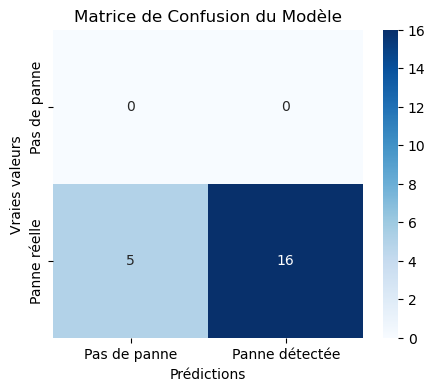

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Création de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage sous forme de tableau
print("Matrice de confusion :")
print(cm)

# Affichage sous forme de graphique
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pas de panne", "Panne détectée"], yticklabels=["Pas de panne", "Panne réelle"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion du Modèle")
plt.show()



In [33]:
for panne in pannes:
    start_panne = pd.to_datetime(panne["start"])
    pre_panne = start_panne - pd.Timedelta(minutes=30)  # Fenêtre de 30 minutes avant la panne

    anomalies_dans_fenetre = df[(df["timestamp"] >= pre_panne) & 
                                (df["timestamp"] <= start_panne) & 
                                (df["failure_detected"])]

    print(f"Panne à {start_panne} → Anomalies détectées dans la fenêtre : {len(anomalies_dans_fenetre)}")


Panne à 2020-04-12 11:50:00 → Anomalies détectées dans la fenêtre : 33
Panne à 2020-04-18 00:00:00 → Anomalies détectées dans la fenêtre : 0
Panne à 2020-04-19 00:00:00 → Anomalies détectées dans la fenêtre : 181
Panne à 2020-04-29 03:20:00 → Anomalies détectées dans la fenêtre : 38
Panne à 2020-04-29 22:00:00 → Anomalies détectées dans la fenêtre : 0
Panne à 2020-05-13 14:00:00 → Anomalies détectées dans la fenêtre : 94
Panne à 2020-05-18 05:00:00 → Anomalies détectées dans la fenêtre : 86
Panne à 2020-05-19 10:10:00 → Anomalies détectées dans la fenêtre : 8
Panne à 2020-05-19 22:10:00 → Anomalies détectées dans la fenêtre : 40
Panne à 2020-05-20 00:00:00 → Anomalies détectées dans la fenêtre : 53
Panne à 2020-05-23 09:50:00 → Anomalies détectées dans la fenêtre : 107
Panne à 2020-05-29 23:30:00 → Anomalies détectées dans la fenêtre : 81
Panne à 2020-05-30 00:00:00 → Anomalies détectées dans la fenêtre : 0
Panne à 2020-06-01 15:00:00 → Anomalies détectées dans la fenêtre : 94
Panne à 

In [ ]:
Interprétation des résultats
-La précision de 1.00 signifie que toutes les anomalies détectées sont correctes, mais le modèle manque trop de pannes.
-Le rappel de 0.14 est trop bas, indiquant que la majorité des pannes réelles ne sont pas détectées.
-Un score F1 de 0.25 montre que le modèle est trop conservateur, il ne signale une panne que si l''erreur de 
 reconstruction est très élevée.
-Le taux de faux positifs est NaN, ce qui signifie qu''il n''y a aucune fausse alerte. 
 Cela peut être un signe que le seuil de détection est trop strict.
